# FRB 180924 Example

In [153]:
# imports
from importlib import reload

from matplotlib import pyplot as plt
import numpy as np

from astropy import units
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import wcs as astropy_wcs

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

import photutils

from frb.surveys import survey_utils
from frb import frb
from frb.associate import bayesian

# Load

In [2]:
frb180924 = frb.FRB.by_name('FRB180924')

In [5]:
search_r = 30 * units.arcsec

## Survey

In [6]:
des_srvy = survey_utils.load_survey_by_name('DES', frb180924.coord, search_r)

## Image

In [7]:
des_r = des_srvy.get_image(60*units.arcsec, 'r')

downloading deepest stacked image...


In [93]:
wcs = astropy_wcs.WCS(des_r.header)

In [18]:
np.median(des_r.data)

0.21114373

### Show me

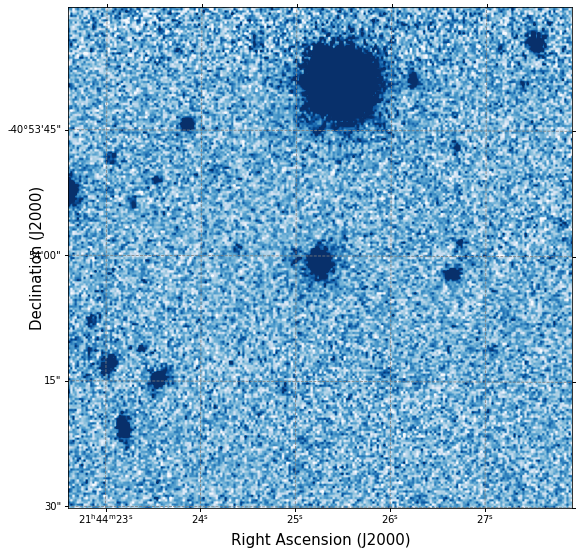

In [65]:
blues = plt.get_cmap('Blues')
fsz = 15.
vmnx=10.
fig = plt.figure(figsize=(7, 7))
aximg = fig.add_axes([0., 0., 1., 1.], projection=wcs)
d = aximg.imshow(des_r.data, cmap=blues, vmin=-vmnx, vmax=vmnx)

plt.grid(color='gray', ls='dashed')
aximg.set_xlabel('Right Ascension (J2000)', fontsize=fsz)
aximg.set_ylabel('Declination (J2000)', fontsize=fsz, labelpad=-2)
#aximg.invert_xaxis()

#aximg = fig.add_axes([x0, y0, xwidth, ywidth], projection=cutout.wcs)
plt.show()


----

# Source Extraction
    https://photutils.readthedocs.io/en/stable/segmentation.html#image-segmentation

## Background

In [38]:
bkg_estimator = photutils.MedianBackground()
bkg = photutils.Background2D(des_r.data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)

## Threshold (could be use a more sophisticated Background)

In [44]:
#threshold = photutils.detect_threshold(des_r.data, nsigma=2.)
threshold = bkg.background + (1.5 * bkg.background_rms)
threshold

array([[6.21796198, 6.21818891, 6.21885905, ..., 6.21043171, 6.20745039,
        6.20450246],
       [6.21792554, 6.21815249, 6.21882267, ..., 6.21045439, 6.20747391,
        6.20452681],
       [6.21781826, 6.21804524, 6.21871552, ..., 6.21052224, 6.20754424,
        6.20459958],
       ...,
       [6.52742757, 6.5274053 , 6.52733917, ..., 6.44187403, 6.44170263,
        6.44153578],
       [6.52720158, 6.52717925, 6.52711294, ..., 6.44171695, 6.44154503,
        6.44137768],
       [6.52697319, 6.52695082, 6.52688436, ..., 6.44156483, 6.44139223,
        6.44122422]])

## Segmentation

### Kernel

In [28]:
sigma = 3.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)  # Might need a somewhat larger one
kernel.normalize()

### Image

In [45]:
segm = photutils.detect_sources(des_r.data, threshold, npixels=3, filter_kernel=kernel)

### Show

Text(0.5, 1.0, 'Segmentation Image')

<Figure size 432x288 with 0 Axes>

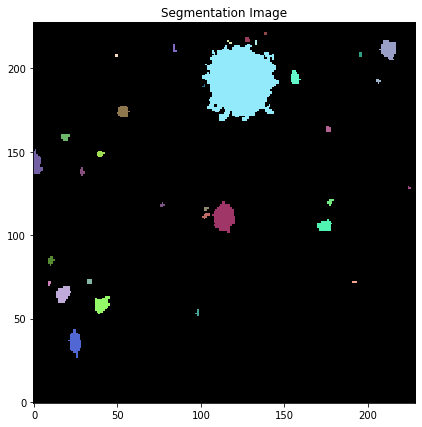

In [46]:
plt.clf()
fig = plt.figure(figsize=(7, 7))

ax2 = plt.gca()
cmap = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

----

# Photometry

## Elliptical apertures

In [59]:
cat = photutils.source_properties(des_r.data, segm, filter_kernel=kernel)

In [60]:
cat

<photutils.segmentation.properties.SourceCatalog>
Catalog length: 33

In [61]:
r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(units.rad).value
    apertures.append(photutils.EllipticalAperture(position, a, b, theta=theta))

## Plot

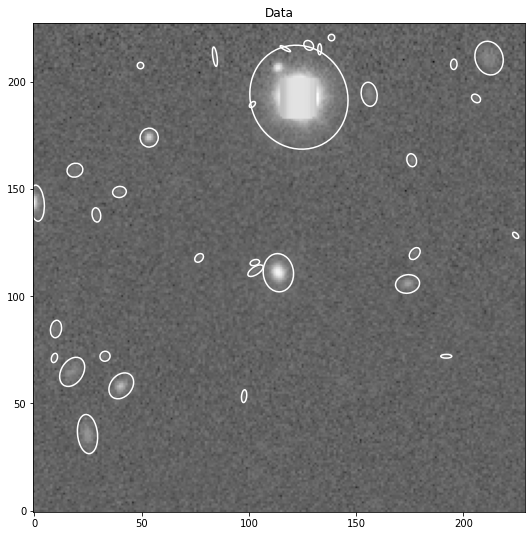

In [62]:
norm = ImageNormalize(stretch=SqrtStretch())
fig = plt.figure(figsize=(9, 9))

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
plt.clf()
ax1 = plt.gca()
ax1.imshow(des_r.data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
#
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    #aperture.plot(axes=ax2, color='white', lw=1.5)


## Table

In [63]:
tbl2 = cat.to_table()
tbl2[0:5]

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float32,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,24.815382801336604,35.7274381979082,None,None,1207.6932,None,None,None,None,21.0,28.0,27.0,43.0,-1.9662222,32.970013,21.0,37.0,26.0,35.0,79.0,5.014626706796775,34.9350288425444,3.053688255930901,1.5468432457339165,-83.98579412459316,0.8622110764069465,0.493450831881865,1.9741420239916072,2.468825361450436,-0.7223329914933082,9.248910629832508,0.41452294468751805,0.06474786289164798,0.11064922126576911,0.3317629751671388
2,97.79011103247225,53.395078214258064,None,None,40.46683,None,None,None,None,97.0,98.0,52.0,55.0,3.1588833,13.374565,98.0,52.0,98.0,53.0,5.0,1.2615662610100802,4.414213562373095,0.9955106043084838,0.3968663995218402,84.26177414556302,0.9171004821233535,0.6013438753899388,2.508427535079596,0.1658355888378838,0.0829225584833309,0.9827087135221877,6.295704906256678,-1.062483625308926,1.0624225835309618,0.32526591614220685
3,40.54798424701132,58.20030412780602,None,None,1382.4095,None,None,None,None,37.0,45.0,53.0,63.0,2.2183409,69.93901,37.0,60.0,40.0,58.0,69.0,4.686510657907603,32.76345596729059,2.2268781828553768,1.6628442891330277,49.813075877528135,0.665143648995854,0.253284574820849,1.3391982625242826,3.6785852016421696,1.08152214859641,4.045452369537419,0.2950332782248912,-0.15774998483529926,0.26827779742075225,0.4340796087007012
4,17.662355438236947,64.7209542980105,None,None,853.78827,None,None,None,None,14.0,22.0,60.0,69.0,-0.5994197,31.198378,17.0,60.0,18.0,65.0,65.0,4.54864184146723,29.31370849898476,2.453534103566753,1.698154370153041,57.683499074239435,0.7217768433443547,0.30787415276421093,1.444823949277141,3.780002898033325,1.416862679758806,5.123554964201655,0.29514325830553384,-0.16323723305296248,0.21774771218908046,0.2829845638605865
5,9.392611716930146,71.20063253713033,None,None,56.70627,None,None,None,None,9.0,10.0,70.0,72.0,8.666496,14.308184,10.0,71.0,9.0,70.0,5.0,1.2615662610100802,5.207106781186548,0.7390469667290787,0.4551682417575425,72.31381821500892,0.7878357479039028,0.38411459318741914,1.6236786729131065,0.23846775665930908,0.09812506174229778,0.5149007906767954,4.550253325913334,-1.7342909416062917,2.107374318528141,0.13250819068620467


## Magnitudes

In [68]:
des_r.header['MAGZERO']

30.0

In [69]:
tbl2['r'] = -2.5*np.log10(tbl2['source_sum']) + 30.

### Check HG 180924
    DR1 gives r=20.50

In [71]:
des_r.shape

(228, 229)

In [85]:
idx = np.argmin( (tbl2['xcentroid'].value-des_r.shape[1]/2)**2 + (tbl2['ycentroid'].value-des_r.shape[0]/2)**2 )
tbl2[idx]['r']
#idx

20.64878

### Good enough

----

# Candidate Table

## Remove Bright star

In [86]:
istar = np.argmin(tbl2['r'])
tbl2[istar]

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,r
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,,
int64,float64,float64,object,object,float32,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32
21,123.33086785611792,192.72157929451484,None,None,62103.156,None,None,None,None,101.0,146.0,169.0,214.0,-7.9474583,199.1418,110.0,208.0,132.0,192.0,1445.0,21.44662643717136,234.58683245815342,8.17520700744316,7.520475996962033,-66.51325031818226,0.3921234424726406,0.08008739226847994,1.0870597832830808,58.18978553669882,-3.7562388129193254,65.20178329873099,0.017249292962327623,0.001987444528124507,0.015394251619450232,0.5008734191933846,18.017216


In [88]:
msk = np.ones(len(tbl2), dtype=boola
msk[istar] = False
candidates = tbl2[msk]

In [89]:
len(candidates)

32

## Separation

### Coords

In [95]:
coords = astropy_wcs.utils.pixel_to_skycoord(candidates['xcentroid'].value, candidates['ycentroid'].value, wcs)

In [96]:
candidates['ra'] = coords.ra.value
candidates['dec'] = coords.dec.value
candidates['coords'] = coords

### Separation

In [99]:
seps = frb180924.coord.separation(candidates['coords'])
candidates['separation'] = seps.to('arcsec')

In [102]:
candidates[['id', 'r', 'separation']][0:5]

id,r,separation
,,arcsec
int64,float32,float64
1,22.295109,31.158441048148333
2,25.982252,16.435456093261166
3,22.148409,24.213628235473834
4,22.671623,28.42131985592967
5,25.615921,29.692000461270528


## Half-light

In [105]:
plate_scale = des_r.header['CD2_2'] * 3600. * units.arcsec  # arcsec
plate_scale

<Quantity 0.263 arcsec>

In [122]:
candidates['half_light'] = candidates['semimajor_axis_sigma'].value * plate_scale

----

# Bayesian Time!

## Priors

### $\bar P(M)$

In [107]:
frb180924.eellipse

{'a': 0.1,
 'a_sys': 0.09,
 'b': 0.1,
 'b_sys': 0.09,
 'cl': 68.0,
 'cl_sys': 68.0,
 'theta': 0.0,
 'theta_sys': 0}

In [109]:
# Ignore any ellipticity
atot = np.sqrt(frb180924.eellipse['a']**2 + frb180924.eellipse['a_sys']**2)
btot = np.sqrt(frb180924.eellipse['b']**2 + frb180924.eellipse['b_sys']**2)

sigR = np.sqrt( atot * btot) * units.arcsec
sigR

<Quantity 0.13453624 arcsec>

In [124]:
candidates['half_light'].value

array([0.80312001, 0.26181929, 0.58566896, 0.64527947, 0.19436935,
       0.209634  , 0.22571498, 0.35814611, 0.78184162, 0.49363614,
       0.35772505, 0.19829157, 0.20252277, 0.27389042, 0.15189085,
       0.29284289, 0.73857509, 0.28063136, 0.32724393, 0.26824853,
       0.38612807, 0.1501825 , 0.49403538, 0.20315113, 0.69758245,
       0.13220034, 0.21234233, 0.39551603, 0.22448758, 0.23838534,
       0.21981691, 0.1316984 ])

In [125]:
raw_prior_Mi = bayesian.prior_Mi_n(candidates['r'].data, candidates['separation'].to('arcsec').value, 
                                   candidates['half_light'].value, sigR.to('arcsec').value)

In [126]:
raw_prior_Mi

array([2.13198994e-02, 1.27351287e-08, 1.25621236e-01, 1.39633673e-02,
       3.94527116e-20, 9.64470696e-08, 1.66868743e-32, 2.57829412e-08,
       9.93285749e-01, 2.23459656e-01, 7.70585634e-01, 5.52919731e-01,
       5.78694185e-03, 1.55681977e-04, 4.87862339e-43, 2.82167598e-08,
       7.33127741e-02, 4.11409217e-05, 5.44987152e-08, 1.65706817e-05,
       1.24753181e-01, 6.81410105e-18, 5.15136756e-03, 3.34515352e-22,
       3.90643060e-03, 7.65136091e-26, 1.61730813e-26, 1.71403131e-14,
       1.26575906e-25, 9.91387542e-26, 1.25760613e-12, 5.63495451e-24])

### $\bar P(S)$

In [127]:
raw_prior_S = 0.01  # Arbitrary!

### $P(M), P(S)$

In [128]:
prior_Mi, prior_S = bayesian.renorm_priors(raw_prior_Mi, raw_prior_S)
prior_Mi, prior_S

(array([7.29065017e-03, 4.35496277e-09, 4.29580116e-02, 4.77497684e-03,
        1.34914294e-20, 3.29814804e-08, 5.70631973e-33, 8.81685231e-09,
        3.39668531e-01, 7.64152846e-02, 2.63512983e-01, 1.89078956e-01,
        1.97892906e-03, 5.32377198e-05, 1.66831634e-43, 9.64913205e-09,
        2.50703711e-02, 1.40687375e-05, 1.86366295e-08, 5.66658600e-06,
        4.26611675e-02, 2.33018111e-18, 1.76158518e-03, 1.14392398e-22,
        1.33586085e-03, 2.61649432e-26, 5.53062075e-27, 5.86137974e-15,
        4.32844748e-26, 3.39019411e-26, 4.30056736e-13, 1.92695478e-24]),
 0.003419645669686968)

In [129]:
candidates['P_M'] = prior_Mi

In [133]:
candidates[['id', 'r', 'half_light', 'separation', 'P_M']][8:15]

id,r,half_light,separation,P_M
,,arcsec,arcsec,
int64,float32,float64,float64,float64
9,20.64878,0.7818416200063633,0.7506282358626138,0.33966853090751986
10,22.81152,0.49363614037751524,15.920874559709109,0.076415284643267
11,24.810978,0.35772504671189936,2.8986299262750115,0.2635129827608303
12,25.921034,0.19829156552489272,2.9826768880454253,0.18907895624623614
13,25.677635,0.2025227698873042,9.829483878702181,0.0019789290647325925
14,24.987389,0.27389042292269206,16.732285105091073,5.323771975394719e-05
15,26.666262,0.1518908528998349,29.27853792064121,1.6683163358642624e-43


### $\theta$ Prior

In [138]:
theta_max = 10 * units.arcsec  # This eliminates most of the candidates;  could do case-by-case

In [139]:
theta_u = dict(method='uniform', max=4.) # This is twice what was actually generated

## Calculate $p(x|M_i)$

In [141]:
p_xMi = bayesian.px_Mi(theta_max.to('arcsec').value, 
                       frb180924.coord, 
                       candidates['coords'], 
                       theta_u, 
                       sigR.to('arcsec').value)

In [142]:
p_xMi

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.0008414, 0.       , 0.0008414, 0.0008414,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])

## Calculate $p(x|S)$
    For our offset prior, the location doesn't matter provided it is within theta_max
    For ones that scale with theta, we might average over random placement..

In [143]:
p_xS = bayesian.px_Mi(theta_max.to('arcsec').value, frb180924.coord, SkyCoord([frb180924.coord]), 
                      theta_u, sigR.to('arcsec').value)[0]
p_xS

0.0008413955421754919

## Calculate $p(x)$

In [144]:
p_x = prior_S*p_xS + np.sum(prior_Mi * p_xMi)  #  I zeroed out P(S)!
p_x

0.000669481702250284

## Evaluate $P(M_i|x)$

In [145]:
P_Mix = prior_Mi * p_xMi / p_x
P_Mix

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.42689081, 0.        ,
       0.33117955, 0.23763187, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [147]:
candidates['P_Mix'] = P_Mix

### Cut

In [148]:
final_cands = P_Mix > 0.01
candidates[['id', 'r', 'half_light', 'separation', 'P_M', 'P_Mix']][final_cands]

id,r,half_light,separation,P_M,P_Mix
,,arcsec,arcsec,,
int64,float32,float64,float64,float64,float64
9,20.64878,0.7818416200063633,0.7506282358626138,0.33966853090751986,0.426890812343728
11,24.810978,0.35772504671189936,2.8986299262750115,0.2635129827608303,0.3311795501730395
12,25.921034,0.19829156552489272,2.9826768880454253,0.18907895624623614,0.23763187308933928


----

# $1/r$ Prior on $\theta$

In [160]:
theta_rcore = dict(method='rcore', core=0.3, max=4.,r_half=candidates['half_light'].value) 

## Evaluate $p(x|M_i)$

In [169]:
reload(bayesian)

<module 'frb.associate.bayesian' from '/home/xavier/Projects/FRB/frb/associate/bayesian.py'>

In [170]:
p_xMi_rcore = bayesian.px_Mi(theta_max.to('arcsec').value, 
                       frb180924.coord, 
                       candidates['coords'], 
                       theta_rcore, 
                       sigR.to('arcsec').value)

In [171]:
p_xMi_rcore

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.29136635e-04, 0.00000000e+00, 9.25004084e-05, 5.24939062e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

## Evaluate $p(x|S)$ -- Now this is more tricky..

In [173]:
p_xS_rcore = bayesian.px_Mi(theta_max.to('arcsec').value, frb180924.coord, coords[0:1], 
                      theta_rcore, sigR.to('arcsec').value)[0]
p_xS_rcore

0.0

## Evaluate $p(x)$

In [175]:
p_x_rcore = prior_S*p_xS_rcore + np.sum(prior_Mi * p_xMi_rcore)  #  I zeroed out P(S)!
p_x_rcore

0.000180064761906731

## Evaluate $P(M_i|x)$

In [178]:
P_Mix_rcore = prior_Mi * p_xMi_rcore / p_x_rcore
P_Mix_rcore

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.80950992, 0.        ,
       0.13536829, 0.0551218 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])